In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\..'))
	print(os.getcwd())
except:
	pass


 # Calculating Elo scores for FRC
 The Elo system was designed by chess master and physics professor Arpad Elo as
 a more accurate way to evaluate relative skill levels in zero-sum, two-player
 games, chiefly chess. The World Chess Federation still uses his system, which
 has since seen widespread use in other fields, such as video games.

 One of the challenges with many analytics around FRC is the reliance on
 inaccurate metrics to evaluate a team's skill level in relation to others.
 These include:

 ## Cumulative Rank Points
 This is the rank system officially used by FRC to rank teams within qualifying
 matches at events. Any team that has competed at any FRC event can tell you it
 comes with a host of problems. For instance, teams can benefit greatly from an
 imbalanced schedule. Since this metric makes no attempt to distinguish between
 the scoring efforts of the individual components of the alliance, a team that
 happens to compete alongside capable robots can be boosted high up in the
 rankings independent of their own ability. In addition, it suffers from the
 changing dynamic of the game from the qualifying to elimination matches -
 teams are forced to play an arbitrarily different game in qualifying matches,
 making decisions, such as placing all their cargo into a single rocket,
 prioritizing the switch over the scale, or crossing additional defenses, that
 are unstrategic in eliminations. As a result, ranking points are an imprecise
 predictor of elimination-match ability.

 ## Winrate
 A classic and simple metric, winrate is used widely in professional sports to
 seed teams for tournaments. Nevertheless, the alliance differentiation problem
 presented by the Rank Point system is even more pronounced in the winrate
 metric, which accounts even less for granular scoring actions. However,
 because it is familiar and simple, winrate nets a lot of attention in FRC,
 most notably surrounding team 254's 2018 season, where they alone achieved a
 1.0 winrate.

 ## Average Win Margin
 Often, people aiming to improve upon a winrate predictor tend to settle on
 average win margin, which appears to provide a more granular image of match
 results, and gives teams more credit for scoring more points - isn't that what
 we're aiming to do anyway? However, the average win margin predictor can fall
 apart under a closer examination of match strategy. In particular, it punishes
 teams that win more competitive matches in eliminations - when 330's alliance
 won the World Championship in 2016 by exactly 0 points, their performance
 under an average win margin predictor decreased.

 ## OPR
 Offensive Power Ranking might be the most contentious statistic in FRC. OPR's
 main claim to fame is its professed ability to pick apart an alliance and
 attempt to determine the contributions of each individual robot using linear
 algebra. Unfortunately I've never had the chance to see an actual analysis of
 how well it manages to make those predictions. While I generally advocate
 against the abuse of OPR, it's basically sound and can give some valuable
 insights. That said, one of the chief assumptions of linear algebra is that
 its predictors are independent, which any alliance captain can tell you is not
 practical. In short, an alliance is more powerful than the sum of its parts,
 and OPR fails to account for this. More importantly for our purposes, though,
 OPR doesn't scale well. By the nature of the calculation, it works best in a
 closed system, with a reasonably limited number of teams and a high density.
 From a linear algebra standpoint, FRC data is too sparse for OPR to be
 computationally practical. This is why sites like frc.divisions.co list a
 maximum OPR, rather than simply giving an absolute OPR rating for a team over
 a season. These same problems are shared by DPR, which is essentially the same
 algorithm but used to predict the depression in the opposing alliance's score,
 i.e. the effect of defense, and also by CCWM (calculated contribution
 to win margin).

 And so we arrive at
 ## Elo
 An Elo ranking system evaluates a match in the context of team skill, and uses
 that to adjust its evaluation of team skill. In essence, scores change more in
 upsets than in expected outcomes, so when 1678 stomps the 8th seeded alliance
 that wasn't able to pick up a second fuel bot, they aren't rewarded
 disproportionately to the difficulty of the match. And when a gearbot alliance
 upsets 2056, each member of the winning alliance gains a lot of points, and
 2056 forfeits them. It's worth noting that the system is zero-sum - every team
 starts with the same number of points, and in each match, points are
 exchanged, given from the losing alliance to the winning one. In this
 implementation, we resolve the skill of each alliance as the sum of the skills
 of its teams, and model each match as a two player, zero-sum game.

In [1]:
# Import data
import pandas as pd
import numpy as np
import math
import typing
import time

YEAR = 2019
FILENAME = f"C:/Users/Sam/Documents/236/Statistics/data/{YEAR}_MatchData_basic.csv"

data = pd.read_csv(FILENAME, index_col=False)


 To be clear, I hate jupyter notebooks. But I don't want to write an actual
 paper, I just want to write some python and talk about data, so unfortunately
 you have to look at my ugly code. So rest assured that all I'm doing here is
 collating match results - turning each group of 6 rows (one for each team in a
 match) into a single row for each match, with a tuple representing the
 alliances. If you're really into figurative coding, you can think of this as
 the condensation of the 6 players in each match into the 2 pseudo-players
 represented by each alliance.

In [2]:
# Data processing
cols_ren = {
    'Key':'Key',
    'Event':'Event',
    'Week':'Week',
    'Competition Level':'comp_level',
    'Match Number': 'match',
    'Set Number': 'set',
}

matches = data.loc[::6, cols_ren.keys()]
matches.reset_index(drop=True, inplace=True)
matches.rename(columns=cols_ren, inplace=True)


In [3]:
# Collate teams into rows
for alliance in ['blue','red']:
    for n in [1,2,3]:
        key = f"{alliance}{n}"
        matches[key] = data.loc[(data.Alliance==alliance) & (data['Robot Number']==n),"Team"].reset_index(drop=True)

# Build tuples from rows
matches['blue'] = list(zip(matches.blue1,matches.blue2,matches.blue3))
matches['red'] = list(zip(matches.red1,matches.red2,matches.red3))
matches = matches.drop(['blue1','blue2','blue3','red1','red2','red3'],axis=1)


In [4]:
# Add results to matches
f = { 'W':1.0, 'L':0.0, 'T':0.5 }
matches['outcome'] = data.loc[::6, 'result'].map(f).reset_index(drop=True)


In [5]:
# Sort matches into approximate order
comp_level_f = { 'qm':0, 'qf':1, 'sf':2, 'f':3 }
matches['comp_level_n'] = matches.comp_level.map(comp_level_f)
matches.sort_values(['Week','Event','comp_level_n','set','match'], inplace=True)
matches.drop(['Event','comp_level_n'], axis=1, inplace=True)
matches.reset_index(inplace=True, drop=True)


 # Constants
 The Elo model does require some moderate tuning, namely of $K$ and $N$:

 * $K$: volatility (the amount rankings tend to change after each match)
 * $N$: The point difference suggesting a 10x difference in ability

 $N$ mostly acts as a scaling constant, whereas $K$ can have some notable
 influence over the course of the season. Sometimes $K$ is varied based on some
 match characteristic, e.g. previous matches played, tournament level, skill
 tier, etc. In the interest of egalitarianism (and simplicity), I use a
 constant $K$ value, which nevertheless has significant predictive power.

 Note that we use a starting elo value of 100 for this model.

In [6]:
# Set constants
N = 100
K = 10
initial = 100


 # Basic ELO Rating
 Here we build out the standard implementation of an ELO rating system. The
 probability of player 1 winning a match is given from $r_1$ and $r_2$, the
 ratings of player 1 and player 2, respectively. The formula for the predicted
 probability is given below:
 $$ \frac{1}{1 + 10^{(r_1 - r_2) / N}} $$
 with $N$ as described above.

In [7]:
# Rating functions

Pair = (float, float)
Alliance = (int, int, int)

def P(r1: float, r2: float) -> float:
    #""" Probability of player 1 winning the match """
    return 1.0 / (1 + math.pow(10, (r2 - r1) / N))

def P_alliance(alliance_1, alliance_2):
    # Probability of alliance 1 winning the match
    r_1 = sum(teams.loc[alliance_1, 'elo'])
    r_2 = sum(teams.loc[alliance_2, 'elo'])

    p_1 = P(r_1, r_2)
    p_2 = P(r_2, r_1)

    return p_1, p_2

def rate(a: Alliance):
    return sum(teams.loc[a,"elo"])

def get_delta_match(match):
    # Subteams is a slice of team elos that should improve efficiency
    b = match['blue']
    r = match['red']

    p_b, p_r = P_alliance(b, r)

    outcome = match['outcome']

    if outcome == 1.0:
        return ( K * (1-p_b), K * (0-p_r) )
    elif outcome == 0.0:
        return ( K * (0-p_b), K * (1-p_r) )
    else:
        return ( K * (0.5-p_b), K * (0.5-p_r) )



In [8]:
# Build empty elo dataframe
teams = pd.DataFrame(index=data.Team.unique())
teams['elo'] = np.ones(len(teams)) * initial


In [9]:
# Calculate elos for season
def process(row):
    d = get_delta_match(row)

    teams.loc[row['blue'],'elo'] += d[0]
    teams.loc[row['red'],'elo'] += d[1]

start = time.time()
matches.apply(process, axis=1)
end = time.time()
print(end - start)


263.8326368331909


 # Interpreting Elo scores
 Immediately, we can begin by using these calculated Elo scores to build a
 ranking of the top 25 teams in Deep Space.

In [10]:
teams.sort_values('elo', ascending=False).head(25)


,elo
1114,219.977794
2056,209.820976
254,208.403307
973,205.711456
3310,204.584318
1678,203.686276
2046,203.222314
148,199.832430
2910,199.516608
1323,198.363148


 Hey, these guys look familiar! We've got 1114 and 2056, two of the most
 successful teams this year, and a ton of other memorable powerhouse teams. I
 personally recognize 20 of the top 25 ranked teams. This is a pretty
 impressive proof of the validity of our ranking.

 We can also use these scores to get a general idea of the distribution of
 skill in FIRST Robotics.

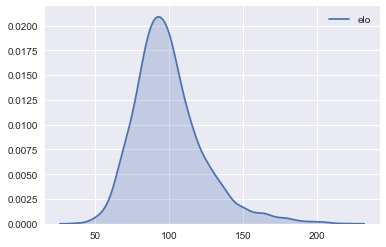

In [11]:
import seaborn as sns; sns.set(color_codes=True)
sns.kdeplot(teams.elo, shade=True)


 First, recall that all teams begin with an elo score of 100. Also keep in mind
 that a significant number of teams compete in exactly 10 matches in their FRC
 season. Thanks to the (flawed) regional system, they go to one regional,
 aren't picked for an alliance, and can't afford to attend another event.
 Meanwhile, they're competing against a lot of teams with similar elo scores,
 level, so they don't get the chance to beat a much higher ranked team or lose
 to a much lower ranked team and accumulate a large point change. As a result,
 many of these teams clump just below 100, as they lose to the teams that move
 into the eliminations.

 We also notice a strong rightward skew to the plot - this makes sense too,
 since **the best teams get to keep playing** and therefore continue to inflate
 their elo score. Dipping into speculation, I would expect that a real skill
 distribution in FRC (which we would see if all teams played the same number of
 matches) is probably right skewed anyways - there's a lot of teams
 (e.g. rookies, low-resource teams) that fall into the middle and lower
 percentiles of skill, while the few teams that excel (the "powerhouse" teams)
 are few, but see much, much more success than the average FRC team.

 # Analyzing individual matches
 Because elo is inherently a probabilistic algorithm, we can use it to predict
 the outcomes of individual matches. Take as an example the 2019 Houston
 Einstein finals with the following alliances:

 | Red | Blue  |
 |------|------|
 | 3310 | 1323 |
 | 254  | 973  |
 | 6986 | 5026 |

 The win probabilities as calculated by our model:

 Note: this model is updated through Houston championships, so it does include
 the Einstein finals. Because it's pretty computationally expensive to rebuild
 the table, I'm making the executive decision to ignore this.

In [12]:
P_alliance([1323,973,5026],[3310,254,6986])


(0.4499558644191424, 0.5500441355808575)

 Our model gives the red alliance a 55% chance of winning the match. Of course
 we know in retrospect that the blue alliance pulled out an upset, but it's
 impressive to see a meaningful prediction of match outcome.

 # Toward the future
 What else can we do with this data? Consider that we have basic match data
 dating back to 2007 available on The Blue Alliance - by compiling this data,
 we can calculate long-term elo scores for every competing FRC team. Perhaps we
 can correlate this model with match scores and generate relevnt predictions.
 We could also use this data to determine the relative "difficulty" of
 schedules before an event takes place. This may also be a jumping-off point
 for even better models, perhaps generated by something like Microsoft's more
 nuanced TrueSkill metric, which uses a more nuanced Bayesian interpretation of
 player skill to account for inconsistency in outcomes.

 # Endnotes
 If you're interested in learning more about the math, check out this [blog
 post](https://blog.mackie.io/the-elo-algorithm) which does a great job of
 explaining the elo algorithm. Thanks also to the developers of [The Blue
 Alliance](http://thebluealliance.com) for the API that was used to retrieve
 the raw data for this project. Credit also goes to Caleb Sykes, who was the
 first (as far as I know) to implement FRC Elo.